# Linear Models

### imports and Load CIFAR-10 dataset

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
data_folder = './../Data/cifar/cifar-10/'
Xtr = np.load(data_folder + 'Xtr.npy')
ytr = np.load(data_folder + 'ytr.npy')
Xte = np.load(data_folder + 'Xte.npy')
yte = np.load(data_folder + 'yte.npy')
labels = read_dictionary = np.load(data_folder + 'labels_dict.npy',allow_pickle='TRUE').item()
true_shape = (32, 32, 3)
# transpose to (1,2,0)
n = int(Xtr.shape[0]*0.8)
Xtr , Xval = Xtr[:n] , Xtr[n:]
ytr , yval = ytr[:n] , ytr[n:]
Xtr.shape , ytr.shape , Xval.shape , yval.shape , Xte.shape , yte.shape , len(labels) , labels

((40000, 3072),
 (40000,),
 (10000, 3072),
 (10000,),
 (10000, 3072),
 (10000,),
 10,
 {0: 'jetliner',
  1: 'shooting',
  2: 'gamecock',
  3: 'domestic',
  4: 'wapiti',
  5: 'toy',
  6: 'green',
  7: 'lippizan',
  8: 'hydrofoil',
  9: 'dustcart'})

In [6]:
Xtr = torch.tensor(Xtr , dtype = torch.float32)
ytr = torch.tensor(ytr , dtype = torch.float32)
Xval = torch.tensor(Xval , dtype = torch.float32)
yval = torch.tensor(yval , dtype = torch.float32)
Xte = torch.tensor(Xte , dtype = torch.float32)
yte = torch.tensor(yte , dtype = torch.float32)

In [7]:
ytr_enc = torch.zeros(ytr.shape[0] , len(labels)) 
yval_enc = torch.zeros(yval.shape[0] , len(labels))
yte_enc = torch.zeros(yte.shape[0] , len(labels))

ytr_enc[torch.arange(ytr.shape[0]) , ytr.long()] = 1
yval_enc[torch.arange(yval.shape[0]) , yval.long()] = 1
yte_enc[torch.arange(yte.shape[0]) , yte.long()] = 1

## Version 1 - Linear Model

In [19]:
W = torch.rand(Xtr.shape[1] ,len(labels) ) * 1e-4
b = torch.rand(1, len(labels) )

print(W.shape, b.shape, Xtr.shape )

def linear1(x , W = W , b= b):
    h = torch.matmul(x, W) + b 
    return h.softmax(dim = 0)
y_p = linear1(Xtr[:2] )
y_p

torch.Size([3072, 10]) torch.Size([1, 10]) torch.Size([40000, 3072])


tensor([[0.0193, 0.0159, 0.0137, 0.0148, 0.0161, 0.0152, 0.0153, 0.0149, 0.0162,
         0.0185],
        [0.9807, 0.9841, 0.9863, 0.9852, 0.9839, 0.9848, 0.9847, 0.9851, 0.9838,
         0.9815]])

In [6]:
n_ex = Xtr.shape[0]
W.shape ,b.shape , Xtr[:n_ex].shape , linear1(Xtr[:n_ex] ).shape ,ytr_enc[:n_ex].shape 

(torch.Size([3072, 10]),
 torch.Size([1, 10]),
 torch.Size([40000, 3072]),
 torch.Size([40000, 10]),
 torch.Size([40000, 10]))

In [20]:
def loss(y,y_pred):
    return -torch.sum(y*torch.log(y_pred)) / y.shape[0]

n_ex = 2
loss(ytr_enc[:n_ex], linear1(Xtr[:n_ex]))

tensor(2.0992)

## BackProp

loss : 

$$
L = -\frac{1}{N} \sum_{i=1}^N y_i \log \hat{y}_i
$$


forward : 
\begin{align*}
\hat{y}_i &= softmax(X_iW + b) \\
& = \frac{e^{X_iW + b}}{\sum_{j} e^{X_jW + b}} \\
& = \frac{e^{X_iW} e^b}{\sum_{j} e^{X_jW} e^b} \\
& = \frac{e^{X_iW} e^b}{e^b \sum_{j} e^{X_jW}} \\
& = \frac{e^{X_iW}}{\sum_{j} e^{X_jW}}
\end{align*}

$$
\frac{d \text{softmax}(x)}{d x} = \text{softmax}(x) \cdot (1 - \text{softmax}(x))
$$

backpropagation:



$$
L = -\frac{1}{N} \sum_{i=1}^N y_i \log \hat{y}_i
$$

$$
\hat{y}_i = softmax(X_iW + b) 
$$

\begin{align*}
    \frac{\partial L}{\partial W} &= -\frac{1}{N} \sum_{i=1}^N  \frac{y_i}{\hat{y}_i} \frac{\partial \hat{y}_i}{\partial W} \\
    &= -\frac{1}{N} \sum_{i=1}^N  \frac{y_i}{\hat{y}_i} \frac{\partial \text{softmax}(X_iW + b)}{\partial W} \\
    &= -\frac{1}{N} \sum_{i=1}^N  \frac{y_i}{\hat{y}_i} \frac{\partial \text{softmax}(X_iW + b)}{\partial (X_iW + b)} \frac{\partial (X_iW + b)}{\partial W} \\
    &= -\frac{1}{N} \sum_{i=1}^N  \frac{y_i}{\hat{y}_i} \text{softmax}(X_iW + b) \cdot (1 - \text{softmax}(X_iW + b)) \cdot X_i \\
    \frac{\partial L}{\partial W}&= -\frac{1}{N} \sum_{i=1}^N  y_i \cdot (1 - \hat{y}_i) \cdot X_i\\
    \frac{\partial L}{\partial b} &= -\frac{1}{N} \sum_{i=1}^N  y_i \cdot (1 - \hat{y}_i)
\end{align*}


In [8]:
ytr_enc[:n_ex].shape , (1 - y_p).shape 
Xtr[:n_ex].shape , (ytr_enc[:n_ex] * (1 - y_p)).shape
((ytr_enc[:n_ex] * (1 - y_p)).T @ Xtr[:n_ex]).T.shape , torch.sum(ytr_enc[:n_ex] * (1 - y_p),dim=0).reshape(1,-1).shape 
W.shape, b.shape

(torch.Size([2, 10]), torch.Size([2, 10]))

(torch.Size([2, 3072]), torch.Size([2, 10]))

(torch.Size([3072, 10]), torch.Size([1, 10]))

(torch.Size([3072, 10]), torch.Size([1, 10]))

In [9]:
dW = ((ytr_enc[:n_ex] * (1 - y_p)).T @ Xtr[:n_ex]).T / y_p.shape[0]
db = torch.sum(ytr_enc[:n_ex] * (1 - y_p),dim=0).reshape(1,-1) / y_p.shape[0]
dW.shape , db.shape
W.shape , b.shape

(torch.Size([3072, 10]), torch.Size([1, 10]))

(torch.Size([3072, 10]), torch.Size([1, 10]))

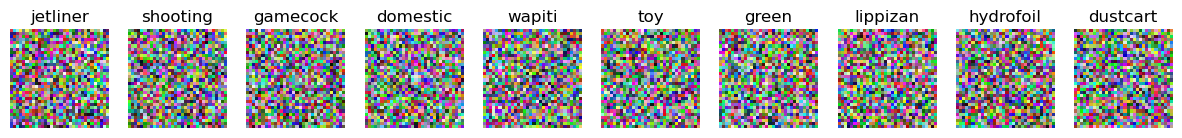

In [10]:
def plot_W(W, labels, true_shape):
    W = W.T
    num_images = W.shape[0]
    W_clipped = W.copy()
    W_clipped -= np.min(W_clipped) 
    W_clipped /= np.max(W_clipped)
    W_clipped *= 255
    W_clipped = W_clipped.astype(np.uint8)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        image = W_clipped[i].reshape(3,32,32).transpose(1,2,0)
        _ = axes[i].imshow(image)
        _ = axes[i].set_title(labels[i])
        _ = axes[i].axis('off')
    plt.show()
plot_W(W.data.numpy() , labels , true_shape)

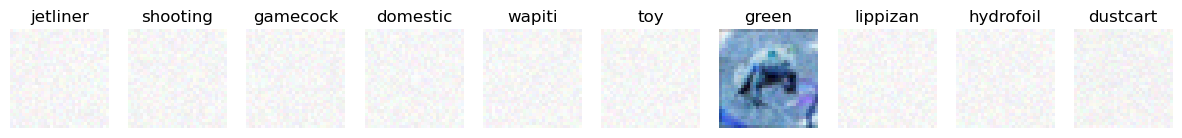

In [11]:
lr = 1e-5
W = W - lr * dW
b = b - lr * db
plot_W(W.data.numpy() , labels , true_shape)

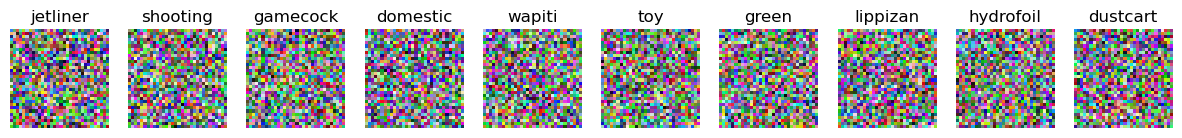

tensor(22.1240)

tensor(nan)

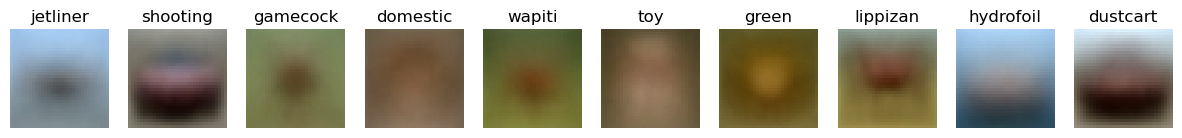

In [21]:
def train(X = Xtr, y_enc = ytr_enc, W=W, b=b, lr=1e-3):
    #forward 
    y_p = linear1(X, W, b)
    l = loss(y_enc, y_p)
    # backward
    dW = ((y_enc * (1 - y_p)).T @ X).T / y_p.shape[0]
    db = torch.sum(y_enc * (1 - y_p),dim=0).reshape(1,-1) / y_p.shape[0]
    W = W + lr * dW
    b = b + lr * db
    return W, b, l
plot_W(W.data.numpy() , labels , true_shape)
W, b, l = train()
l
l_new = loss(ytr_enc, linear1(Xtr, W, b)) 
l_new
plot_W(W.data.numpy() , labels , true_shape)

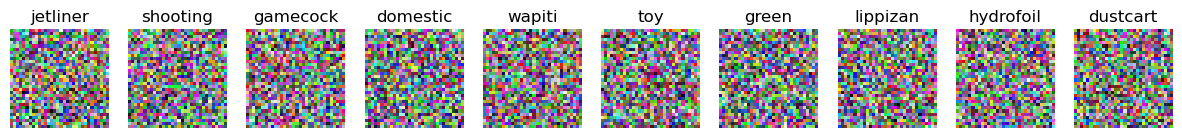

Iter: 0, Loss: 22.123981475830078
Iter: 1, Loss: 22.123981475830078
Iter: 2, Loss: 22.123981475830078
Iter: 3, Loss: 22.123981475830078
Iter: 4, Loss: 22.123981475830078
Iter: 5, Loss: 22.123981475830078
Iter: 6, Loss: 22.123981475830078
Iter: 7, Loss: 22.123981475830078
Iter: 8, Loss: 22.123981475830078
Iter: 9, Loss: 22.123981475830078


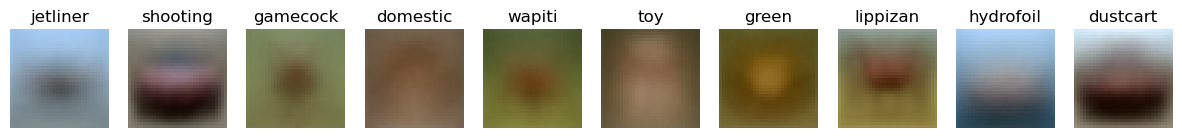

In [32]:
W = torch.rand(Xtr.shape[1] ,len(labels)) 
b = torch.rand(1, len(labels) )

max_iter = 10
plot_W(W.data.numpy() , labels , true_shape)
for iter in range(max_iter):
    W, b, l = train(lr= 1e-2)
    if iter % (max_iter//10) == 0:
        print(f'Iter: {iter}, Loss: {l}')
        if iter % (max_iter//5) == 0:
            # plot_W(W.data.numpy() , labels , true_shape)
            pass
plot_W(W.data.numpy() , labels , true_shape)


## Version 2 - Linear Model with Pytorch 

In [19]:
def plot_W(W, labels, true_shape):
    W = W.T
    num_images = W.shape[0]
    W_clipped = W.copy()
    W_clipped -= np.min(W_clipped) 
    W_clipped /= np.max(W_clipped)
    W_clipped *= 255
    W_clipped = W_clipped.astype(np.uint8)
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        image = W_clipped[i].reshape(3,32,32).transpose(1,2,0)
        _ = axes[i].imshow(image)
        _ = axes[i].set_title(labels[i])
        _ = axes[i].axis('off')
    plt.show()

In [23]:
class Linear1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Linear1, self).__init__()
        self.W = nn.Parameter(torch.rand(input_dim, output_dim) * 0.0001) 
        self.b = nn.Parameter(torch.rand(output_dim))

    def forward(self, x):
        return x @ self.W + self.b

input_dim = Xtr.shape[1]
output_dim = len(labels)
learning_rate = 1e-5
losses = []
num_epochs = 100

model = Linear1(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

Epoch 1/100, Loss: 386.0743
Epoch 2/100, Loss: 250.1049
Epoch 3/100, Loss: 144.6015
Epoch 4/100, Loss: 69.3586
Epoch 5/100, Loss: 22.9852
Epoch 6/100, Loss: 2.3641
Epoch 7/100, Loss: 2.2507
Epoch 8/100, Loss: 15.4515
Epoch 9/100, Loss: 33.9554
Epoch 10/100, Loss: 50.7366
Epoch 11/100, Loss: 61.2398
Epoch 12/100, Loss: 63.7860
Epoch 13/100, Loss: 59.0151
Epoch 14/100, Loss: 48.9630
Epoch 15/100, Loss: 36.2189
Epoch 16/100, Loss: 23.3116
Epoch 17/100, Loss: 12.3099
Epoch 18/100, Loss: 4.5854
Epoch 19/100, Loss: 0.7062
Epoch 20/100, Loss: 0.4548
Epoch 21/100, Loss: 2.9689
Epoch 22/100, Loss: 6.9909
Epoch 23/100, Loss: 11.1771
Epoch 24/100, Loss: 14.3938
Epoch 25/100, Loss: 15.9269
Epoch 26/100, Loss: 15.5634
Epoch 27/100, Loss: 13.5479
Epoch 28/100, Loss: 10.4487
Epoch 29/100, Loss: 6.9813
Epoch 30/100, Loss: 3.8342
Epoch 31/100, Loss: 1.5271
Epoch 32/100, Loss: 0.3254
Epoch 33/100, Loss: 0.2184
Epoch 34/100, Loss: 0.9591
Epoch 35/100, Loss: 2.1532
Epoch 36/100, Loss: 3.3701
Epoch 37/100,

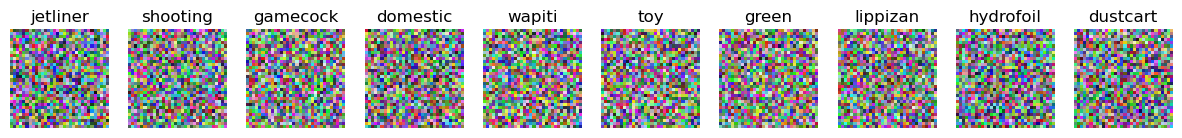

0.10775314271450043

In [24]:

for epoch in range(num_epochs):

    predictions = model(Xtr)
    loss = criterion(predictions, ytr_enc)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")
    losses.append(loss.item())    
plot_W(model.W.data.numpy(), labels, true_shape)
criterion(model(Xtr), ytr_enc).item()

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training Loss')

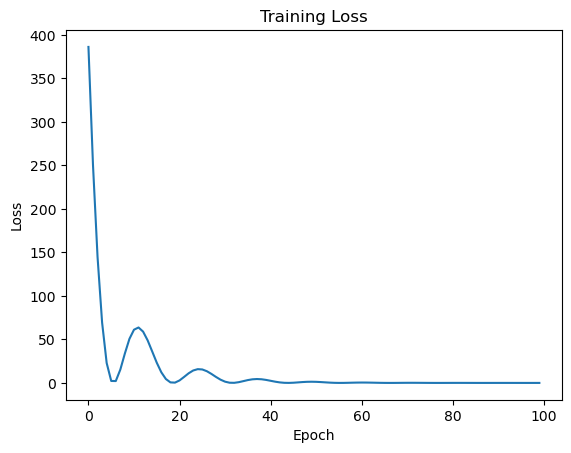

In [26]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [28]:
y_pred = model(Xte) 
y_pred = y_pred.argmax(dim=1) 
acc = (y_pred == yte).float().mean()
acc.item() * 100

18.930000066757202

In [36]:
W_ = model.W.data.numpy()
b_ = model.b.data.numpy()
b_ = b_.reshape(-1,1)
W_.shape , b_.shape 

((3072, 10), (10, 1))

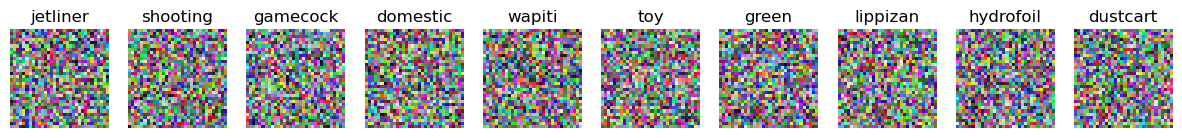

In [37]:
plot_W(W_.T, labels, true_shape)

Epoch 100/1000, Loss: 0.1057
Epoch 200/1000, Loss: 0.1002
Epoch 300/1000, Loss: 0.0986
Epoch 400/1000, Loss: 0.0976
Epoch 500/1000, Loss: 0.0969
Epoch 600/1000, Loss: 0.0963
Epoch 700/1000, Loss: 0.0959
Epoch 800/1000, Loss: 0.0955
Epoch 900/1000, Loss: 0.0951
Epoch 1000/1000, Loss: 0.0948


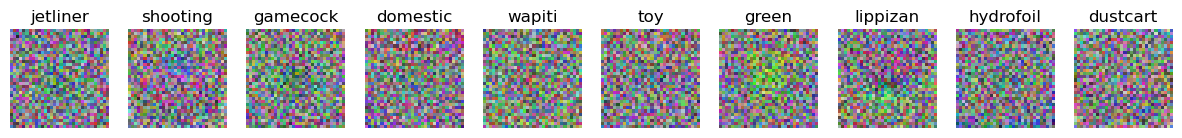

In [12]:
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    predictions = model(Xtr)
    loss = criterion(predictions, ytr_enc)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

plot_W(model.W.data.numpy().T, labels, true_shape)

In [13]:
np.array(list(labels.keys()))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [14]:
inds = []
for i in range(10):
    inds.append(np.where(ytr == i)[0][10])
inds

[179, 75, 57, 78, 98, 156, 124, 87, 161, 76]

In [15]:
Wk = Xtr[inds].data.numpy()
Wk

array([[  2.,   1.,   1., ...,   1.,   1.,   1.],
       [ 65.,  76., 188., ..., 107., 108., 110.],
       [ 66.,  71.,  88., ..., 116., 113., 111.],
       ...,
       [ 39.,  40.,  41., ...,  98.,  98.,  95.],
       [113., 113., 113., ...,  22.,  27.,  27.],
       [118., 110., 118., ..., 128., 127., 119.]], dtype=float32)

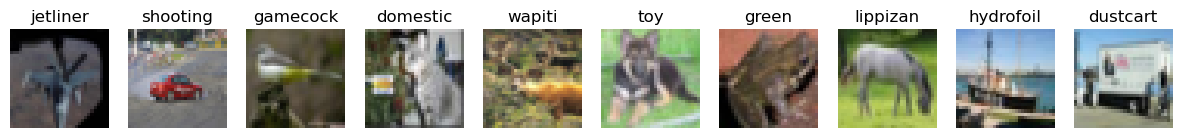

In [16]:
plot_W(Wk, labels, true_shape)

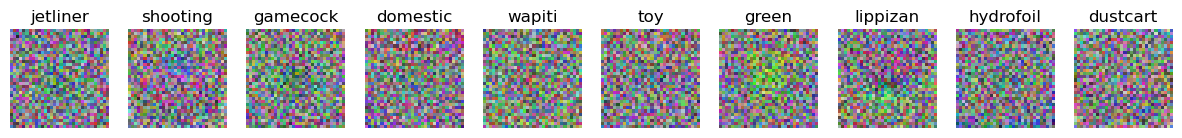

In [17]:
plot_W(model.W.data.numpy().T, labels, true_shape)

In [18]:
optimizer.param_groups[0]['lr'] = 1e-6

Epoch 0/10000, Loss: 0.0948
Epoch 1000/10000, Loss: 0.0945
Epoch 2000/10000, Loss: 0.0940
Epoch 3000/10000, Loss: 0.0935
Epoch 4000/10000, Loss: 0.0930
Epoch 5000/10000, Loss: 0.0925
Epoch 6000/10000, Loss: 0.0920
Epoch 7000/10000, Loss: 0.0915
Epoch 8000/10000, Loss: 0.0910
Epoch 9000/10000, Loss: 0.0911
Epoch 10000/10000, Loss: 0.0903


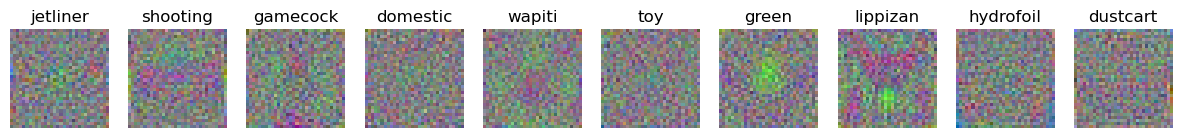

In [19]:
num_epochs = 10000
print(f"Epoch {0}/{num_epochs}, Loss: {loss.item():.4f}")
for epoch in range(num_epochs):
    # Forward pass
    predictions = model(Xtr)
    loss = criterion(predictions, ytr_enc)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

plot_W(model.W.data.numpy().T, labels, true_shape)

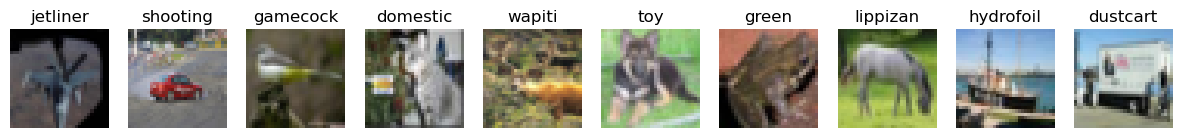

In [ ]:
plot_W(Wk, labels, true_shape)

Epoch 0/10000, Loss: 0.0903
Epoch 1000/10000, Loss: 0.0900
Epoch 2000/10000, Loss: 0.0900
Epoch 3000/10000, Loss: 0.0896
Epoch 4000/10000, Loss: 0.0894
Epoch 5000/10000, Loss: 0.0894
Epoch 6000/10000, Loss: 0.0892
Epoch 7000/10000, Loss: 0.0890
Epoch 8000/10000, Loss: 0.0889
Epoch 9000/10000, Loss: 0.0889
Epoch 10000/10000, Loss: 0.0889


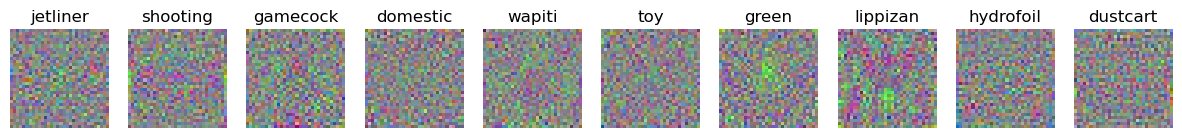

In [21]:
num_epochs = 10000
print(f"Epoch {0}/{num_epochs}, Loss: {loss.item():.4f}")
for epoch in range(num_epochs):
    # Forward pass
    predictions = model(Xtr)
    loss = criterion(predictions, ytr_enc)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

plot_W(model.W.data.numpy().T, labels, true_shape)

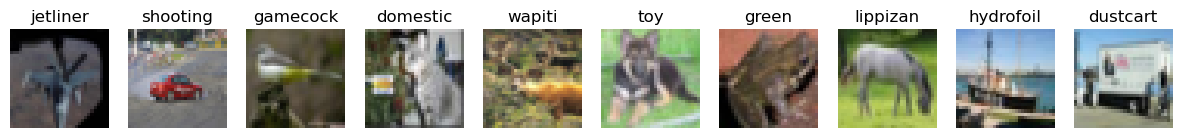

In [22]:
plot_W(Wk, labels, true_shape)

Epoch 0/10000, Loss: 0.0889
Epoch 1000/10000, Loss: 0.0886
Epoch 2000/10000, Loss: 0.0885
Epoch 3000/10000, Loss: 0.0885
Epoch 4000/10000, Loss: 0.0884
Epoch 5000/10000, Loss: 0.0883
Epoch 6000/10000, Loss: 0.0882
Epoch 7000/10000, Loss: 0.0881
Epoch 8000/10000, Loss: 0.0881
Epoch 9000/10000, Loss: 0.0881
Epoch 10000/10000, Loss: 0.0879


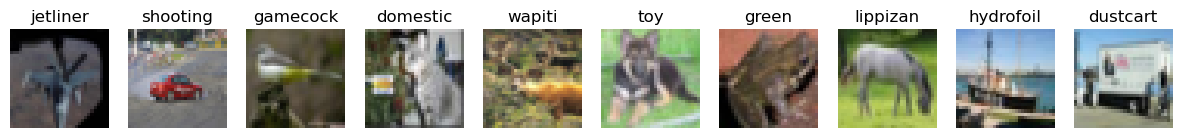

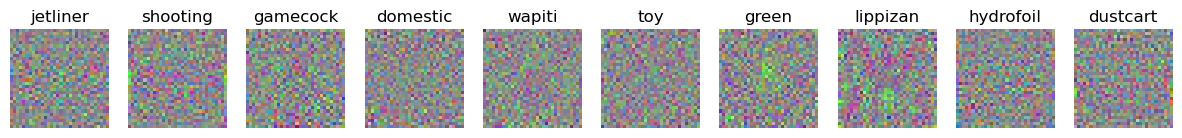

In [23]:
num_epochs = 10000
print(f"Epoch {0}/{num_epochs}, Loss: {loss.item():.4f}")
for epoch in range(num_epochs):
    # Forward pass
    predictions = model(Xtr)
    loss = criterion(predictions, ytr_enc)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

plot_W(Wk, labels, true_shape)
plot_W(model.W.data.numpy().T, labels, true_shape)

Epoch 0/10000, Loss: 0.0879
Epoch 1000/10000, Loss: 0.0878
Epoch 2000/10000, Loss: 0.0879
Epoch 3000/10000, Loss: 0.0879
Epoch 4000/10000, Loss: 0.0876
Epoch 5000/10000, Loss: 0.0876
Epoch 6000/10000, Loss: 0.0876
Epoch 7000/10000, Loss: 0.0874
Epoch 8000/10000, Loss: 0.0873
Epoch 9000/10000, Loss: 0.0873
Epoch 10000/10000, Loss: 0.0873


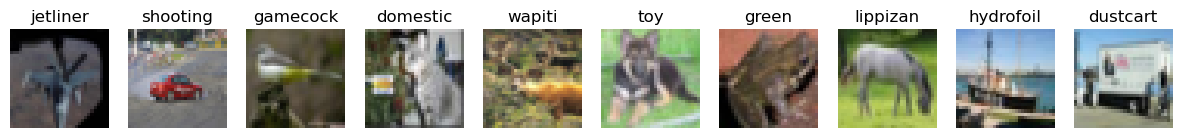

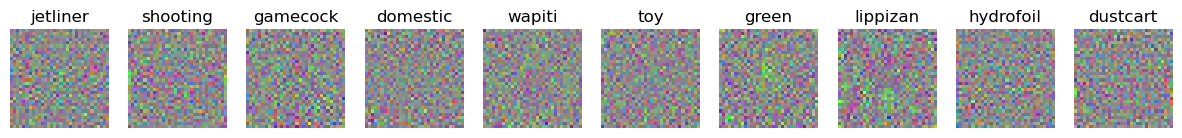

In [24]:
num_epochs = 10000
print(f"Epoch {0}/{num_epochs}, Loss: {loss.item():.4f}")
for epoch in range(num_epochs):
    # Forward pass
    predictions = model(Xtr)
    loss = criterion(predictions, ytr_enc)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

plot_W(Wk, labels, true_shape)
plot_W(model.W.data.numpy().T, labels, true_shape)